# Impage Generator using U-Net generator and Patch gan discriminator

- ## Understaning about Patch gan discriminator and CGan

 - https://sahiltinky94.medium.com/understanding-patchgan-9f3c8380c207

 - https://brstar96.github.io/devlog/mldlstudy/2019-05-13-what-is-patchgan-D/
- ## U-net and U-net generator
 - https://medium.com/@msmapark2/u-net-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-u-net-convolutional-networks-for-biomedical-image-segmentation-456d6901b28a
 - https://pasus.tistory.com/204
 - original paper : https://arxiv.org/abs/1505.04597


- ## Datasets
 - https://www.cityscapes-dataset.com/





### Package and settings

In [ ]:
!pip install torchviz hiddenlayer netron onnx

In [3]:
from os import listdir
from os.path import join
import random
import os
import time
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import ToTensor
from torch import optim

from torchviz import make_dot
import hiddenlayer as hl
import netron

import albumentations as A
import numpy
import cv2
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
%matplotlib inline

print(numpy.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1.22.4


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon May 29 15:32:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Transformer for resize

In [6]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                    transforms.Resize((256,256))
])

### Data augmentation
- HorizontalFlip
- ShiftScaleRotate
- CoarseDropout

In [7]:
class Augmentation:
  def __init__(self, size, mode='train'):
    if mode == 'train':
      self.transform = A.Compose(
          [
              A.HorizontalFlip(p=0.5),
              A.ShiftScaleRotate(
                p=0.5,
                shift_limit=0.05,
                scale_limit=0.05,
                rotate_limit=15,
              ),
              A.CoarseDropout(
                  p=0.5,
                  max_holes=8,
                  max_height=int(0.1 * size),
                  max_width=int(0.1 * size),
              ),
              A.RandomBrightnessContrast(p=0.2),
          ],
          additional_targets={'segmentation': 'image'}  # Declare segmentation image as an additional target
      )

  def __call__(self, image, segmentation):
    if self.transform:
      augmented = self.transform(image=image, segmentation=segmentation)  # Pass both images to the transformation
      img = augmented['image']
      seg_img = augmented['segmentation']
      return img, seg_img

# Example usage
size = 256  # Specify the desired size
augmentor = Augmentation(size)

### Train and Val dataset pipeline

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Text(0.5, 1.0, 'Ground Truth')

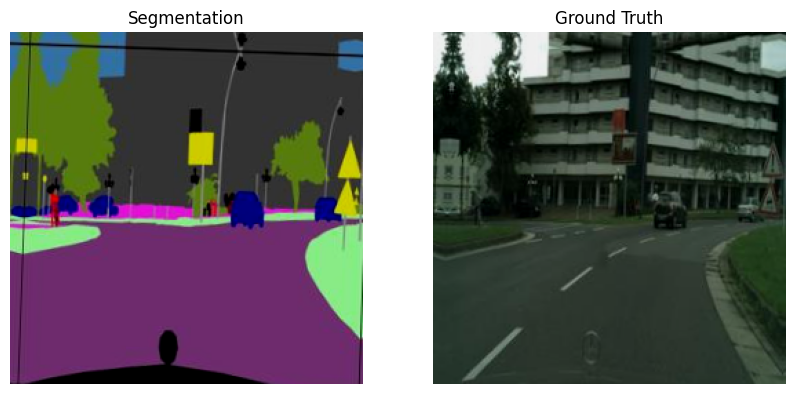

In [8]:
class FacadeDataset(Dataset):
    def __init__(self, path2img, direction='b2a', transform=False, train = True):
        super().__init__()
        self.direction = direction
        self.img_filenames = [f"{x}.jpg" for x in range(1, 1001)]
        self.path2img = path2img
        self.transform = Augmentation(256)
        self.transform2 = transform
        self.to_tensor = ToTensor()
        self.train = train

    def __getitem__(self, index):
        img_path = os.path.join(self.path2img, self.img_filenames[index])
        img = Image.open(img_path)
        img = ToTensor()(img)
        img = torch.transpose(img, 0 , 1)
        img = torch.transpose(img, 1 , 2)
        w = img.shape[1] // 2
        sketch = img[:, :w, :]
        sketch = sketch.float()
        colored = img[:, w:, :]
        colored = colored.float()
        # plt.figure(figsize=(10,7))
        # plt.subplot(1,2,1); plt.imshow(sketch)
        # plt.subplot(1,2,2); plt.imshow(colored)
        if self.transform and self.train == True:
            img, seg = self.transform(np.array(sketch), np.array(colored))

        if self.direction == 'b2a' and self.train ==True:
            return self.transform2(seg), self.transform2(img)
        else:
            return self.transform2(np.array(colored)), self.transform2(np.array(sketch))



    def __len__(self):
        return len(self.img_filenames)

path2img = '/content/drive/MyDrive/AIFFEL/Gan/cityscapes/train'
train_ds = FacadeDataset(path2img, transform=transform)
#Sample images
a, b = train_ds[0]
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(to_pil_image(0.5 * a + 0.5))
plt.axis('off')
plt.title('Segmentation')
plt.subplot(1, 2, 2)
plt.imshow(to_pil_image(0.5 * b + 0.5))
plt.axis('off')
plt.title('Ground Truth')

In [9]:
path2val = '/content/drive/MyDrive/AIFFEL/Gan/cityscapes/val'
val_ds = FacadeDataset(path2img, transform=transform, train = False)

Text(0.5, 1.0, 'Ground Truth')

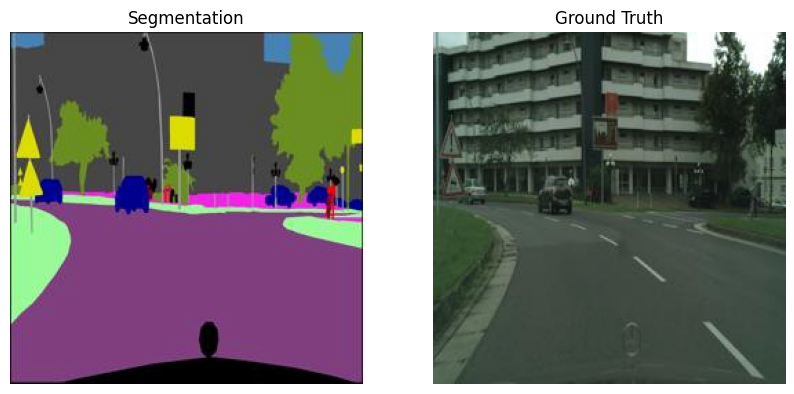

In [10]:
#Sample images
a, b = val_ds[0]
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(to_pil_image(0.5 * a + 0.5))
plt.axis('off')
plt.title('Segmentation')
plt.subplot(1, 2, 2)
plt.imshow(to_pil_image(0.5 * b + 0.5))
plt.axis('off')
plt.title('Ground Truth')

In [11]:
#Train pipeline
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

#Val pipeline
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

### Model setup

#### U-net 

In [12]:
# UNet
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]

        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels)),

        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.down = nn.Sequential(*layers)

    def forward(self, x):
        x = self.down(x)
        return x

# check
x = torch.randn(16, 3, 256,256, device=device)
model = UNetDown(3,64).to(device)
down_out = model(x)
print(down_out.shape)

torch.Size([16, 64, 128, 128])


In [13]:
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels,4,2,1,bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU()
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.up = nn.Sequential(*layers)

    def forward(self,x,skip):
        x = self.up(x)
        x = torch.cat((x,skip),1)
        return x

# check
x = torch.randn(16, 128, 64, 64, device=device)
model = UNetUp(128,64).to(device)
out = model(x,down_out)
print(out.shape)

torch.Size([16, 128, 128, 128])


#### U-net generator

In [14]:
# generator: Generate fake images
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64,128)                 
        self.down3 = UNetDown(128,256)               
        self.down4 = UNetDown(256,512,dropout=0.5) 
        self.down5 = UNetDown(512,512,dropout=0.5)      
        self.down6 = UNetDown(512,512,dropout=0.5)             
        self.down7 = UNetDown(512,512,dropout=0.5)              
        self.down8 = UNetDown(512,512,normalize=False,dropout=0.5)

        self.up1 = UNetUp(512,512,dropout=0.5)
        self.up2 = UNetUp(1024,512,dropout=0.5)
        self.up3 = UNetUp(1024,512,dropout=0.5)
        self.up4 = UNetUp(1024,512,dropout=0.5)
        self.up5 = UNetUp(1024,256)
        self.up6 = UNetUp(512,128)
        self.up7 = UNetUp(256,64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128,3,4,stride=2,padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8,d7)
        u2 = self.up2(u1,d6)
        u3 = self.up3(u2,d5)
        u4 = self.up4(u3,d4)
        u5 = self.up5(u4,d3)
        u6 = self.up6(u5,d2)
        u7 = self.up7(u6,d1)
        u8 = self.up8(u7)

        return u8

# check
x = torch.randn(16,3,256,256,device=device)
model_gen = GeneratorUNet().to(device)
out = model_gen(x)
print(out.shape)

torch.Size([16, 3, 256, 256])


### Visualization Model architecture

In [108]:
make_dot(out, params=dict(model_gen.named_parameters())).render("generator_unet_graph", format="png")

'generator_unet_graph.png'

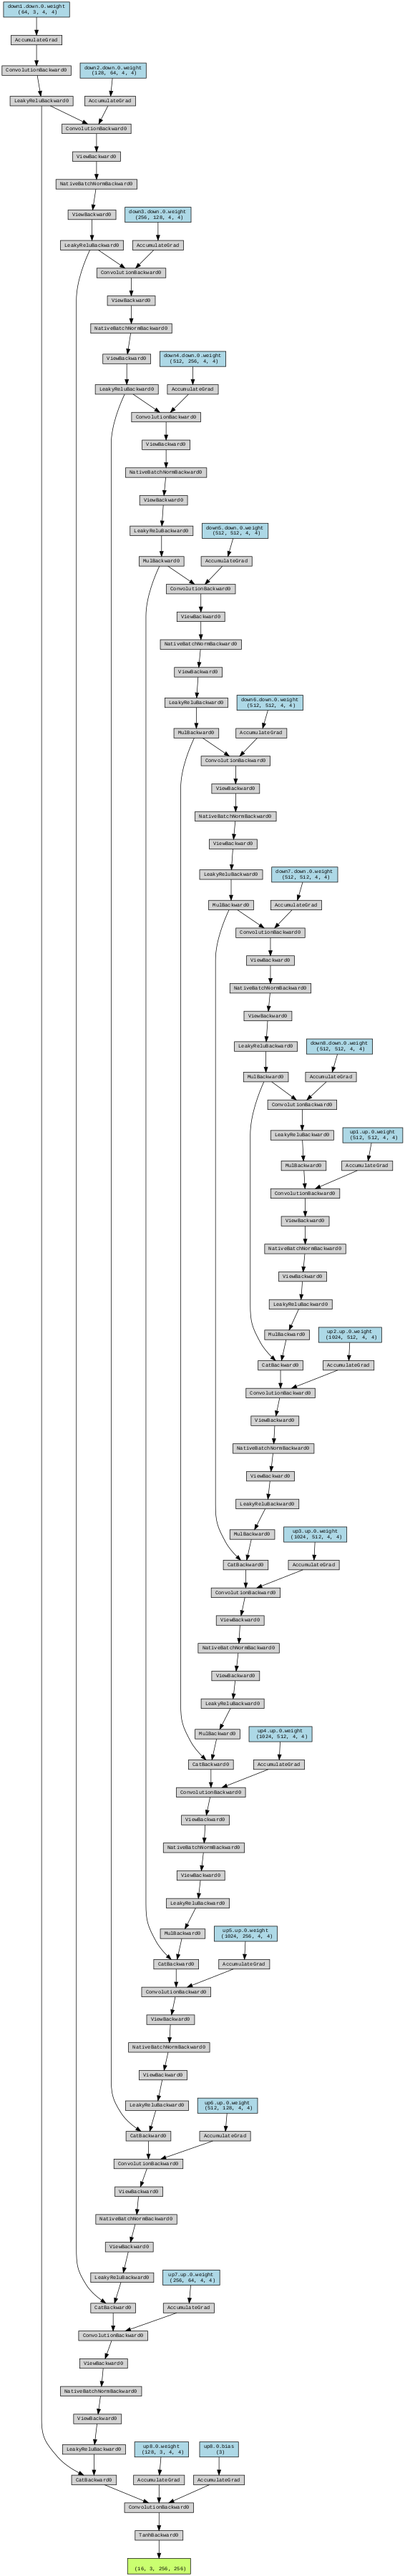

#### Disciminate block

In [15]:
class Dis_block(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
    
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x

# check
x = torch.randn(16,64,128,128,device=device)
model = Dis_block(64,128).to(device)
out = model(x)
print(out.shape)

torch.Size([16, 128, 64, 64])


#### Discriminator using patch Gan

In [16]:
# Using patch Gan for Discriminator model.
# Patch Gan: Desciminate fake image for given patch size.
# Got more accuracy for high-frequency space.

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.stage_1 = Dis_block(in_channels*2,64,normalize=False)
        self.stage_2 = Dis_block(64,128)
        self.stage_3 = Dis_block(128,256)
        self.stage_4 = Dis_block(256,512)

        self.patch = nn.Conv2d(512,1,3,padding=1) # Make 16 x 16 patch

    def forward(self,a,b):
        x = torch.cat((a,b),1)
        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.stage_4(x)
        x = self.patch(x)
        x = torch.sigmoid(x)
        return x
# check
x = torch.randn(16,3,256,256,device=device)
model_dis = Discriminator().to(device)
out = model_dis(x,x)
print(out.shape)

torch.Size([16, 1, 16, 16])


In [138]:
make_dot(out, params=dict(model_dis.named_parameters())).render("model_dis", format="png")

'model_dis.png'

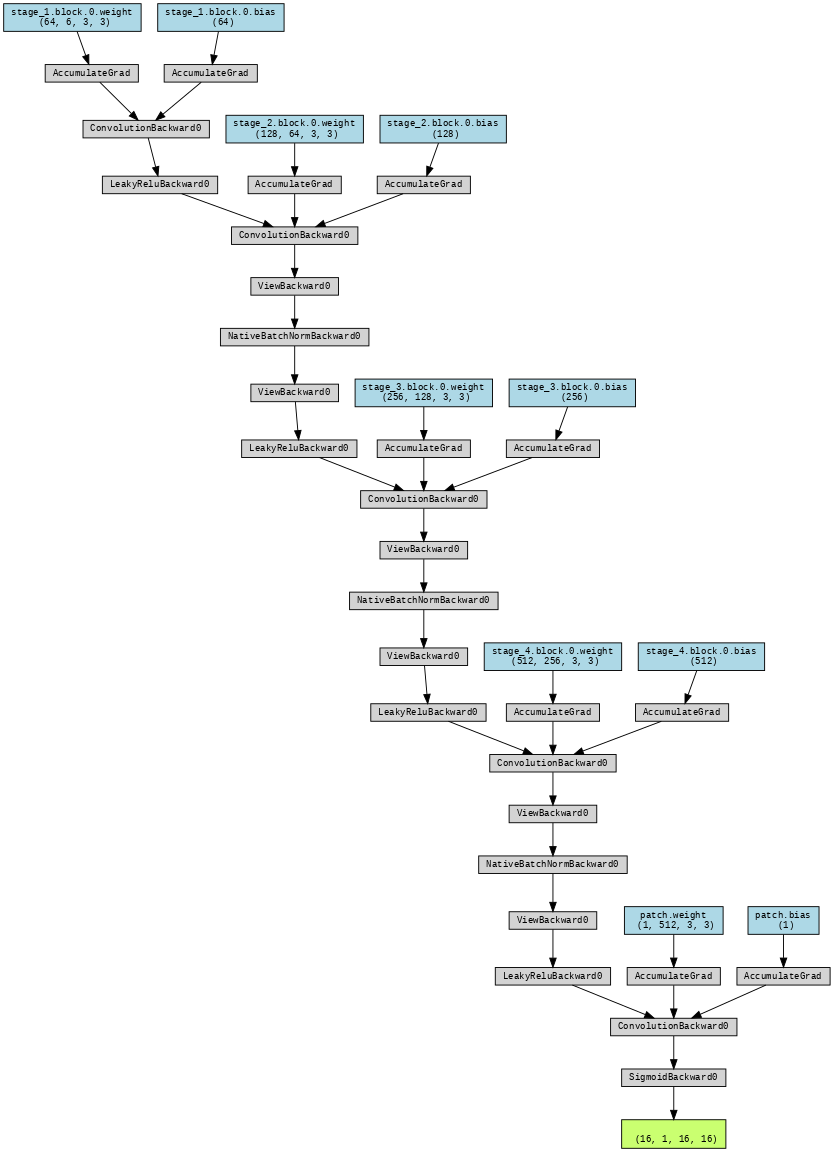

### Initialize settings

In [17]:
# initialize_weights
def initialize_weights(model):
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)


# Initialize weights
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [18]:
# Loss
loss_func_gan = nn.BCELoss()
loss_func_pix = nn.L1Loss()

# loss_func_pix weight
lambda_pixel = 100

# patch coefficient
patch = (1,256//2**4,256//2**4)

# Optimal parameter
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,beta2))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,beta2))

### Model training

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

In [19]:
# writer = SummaryWriter()

# Training step
model_gen.train()
model_dis.train()

batch_count = 0
num_epochs = 100
start_time = time.time()

loss_hist = {'gen':[],
             'dis':[]}

for epoch in range(num_epochs):
    for a, b in train_dl:
        ba_si = a.size(0)

        # real image
        real_a = a.to(device)
        real_b = b.to(device)

        # patch label
        real_label = torch.ones(ba_si, *patch, requires_grad=False).to(device)
        fake_label = torch.zeros(ba_si, *patch, requires_grad=False).to(device)

        # generator
        model_gen.zero_grad()

        fake_b = model_gen(real_a) # Generate Fake image
        out_dis = model_dis(fake_b, real_b) # Discrimiate fake image

        gen_loss = loss_func_gan(out_dis, real_label)
        pixel_loss = loss_func_pix(fake_b, real_b)

        g_loss = gen_loss + lambda_pixel * pixel_loss
        g_loss.backward()
        opt_gen.step()

        # discriminator
        model_dis.zero_grad()

        out_dis = model_dis(real_b, real_a) # Discriminate real image
        real_loss = loss_func_gan(out_dis,real_label)
        
        out_dis = model_dis(fake_b.detach(), real_a) # Discriminate fake image
        fake_loss = loss_func_gan(out_dis,fake_label)

        d_loss = (real_loss + fake_loss) / 2.
        d_loss.backward()
        opt_dis.step()

        loss_hist['gen'].append(g_loss.item())
        loss_hist['dis'].append(d_loss.item())

        batch_count += 1
        if batch_count % 100 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, g_loss.item(), d_loss.item(), (time.time()-start_time)/60))
         #For tensorboard
        #     writer.add_scalar("g_loss/train", g_loss.item(), epoch)
        #     writer.add_scalar("d_loss/train", d_loss.item(), epoch)
        #     writer.flush()
        # writer.close()

Epoch: 3, G_Loss: 17.719879, D_Loss: 0.133228, time: 13.76 min
Epoch: 6, G_Loss: 18.570377, D_Loss: 0.957764, time: 15.53 min
Epoch: 9, G_Loss: 17.059633, D_Loss: 0.029628, time: 17.29 min
Epoch: 12, G_Loss: 15.962736, D_Loss: 0.011516, time: 19.06 min
Epoch: 15, G_Loss: 16.014402, D_Loss: 0.014614, time: 20.82 min
Epoch: 18, G_Loss: 15.675097, D_Loss: 0.009866, time: 22.59 min
Epoch: 21, G_Loss: 16.445250, D_Loss: 0.294293, time: 24.32 min
Epoch: 24, G_Loss: 15.628977, D_Loss: 0.025661, time: 26.06 min
Epoch: 28, G_Loss: 15.149616, D_Loss: 0.007108, time: 27.79 min
Epoch: 31, G_Loss: 16.202396, D_Loss: 0.006737, time: 29.53 min
Epoch: 34, G_Loss: 15.429249, D_Loss: 0.006381, time: 31.27 min
Epoch: 37, G_Loss: 14.641599, D_Loss: 0.004198, time: 33.02 min
Epoch: 40, G_Loss: 15.865270, D_Loss: 0.008202, time: 34.76 min
Epoch: 43, G_Loss: 15.394346, D_Loss: 0.004108, time: 36.52 min
Epoch: 46, G_Loss: 16.015381, D_Loss: 0.024090, time: 38.27 min
Epoch: 49, G_Loss: 13.354888, D_Loss: 0.011

### G_loss and D_loss per epochs

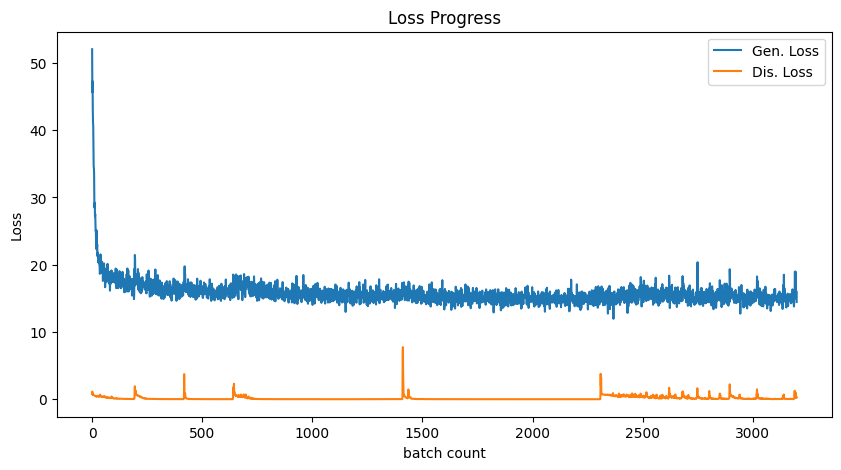

In [20]:
# loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#For tensorboard
# $ tensorboard --logdir=runs

In [21]:
#Save weight
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [22]:
#Load weight
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

<All keys matched successfully>

### Training data Generate

In [23]:
# evaluation model
model_gen.eval()

#Generate fake images
with torch.no_grad():
    for a,b in train_dl:
        ground_truth = b
        fake_imgs = model_gen(a.to(device)).detach().cpu()
        real_imgs = a
        break

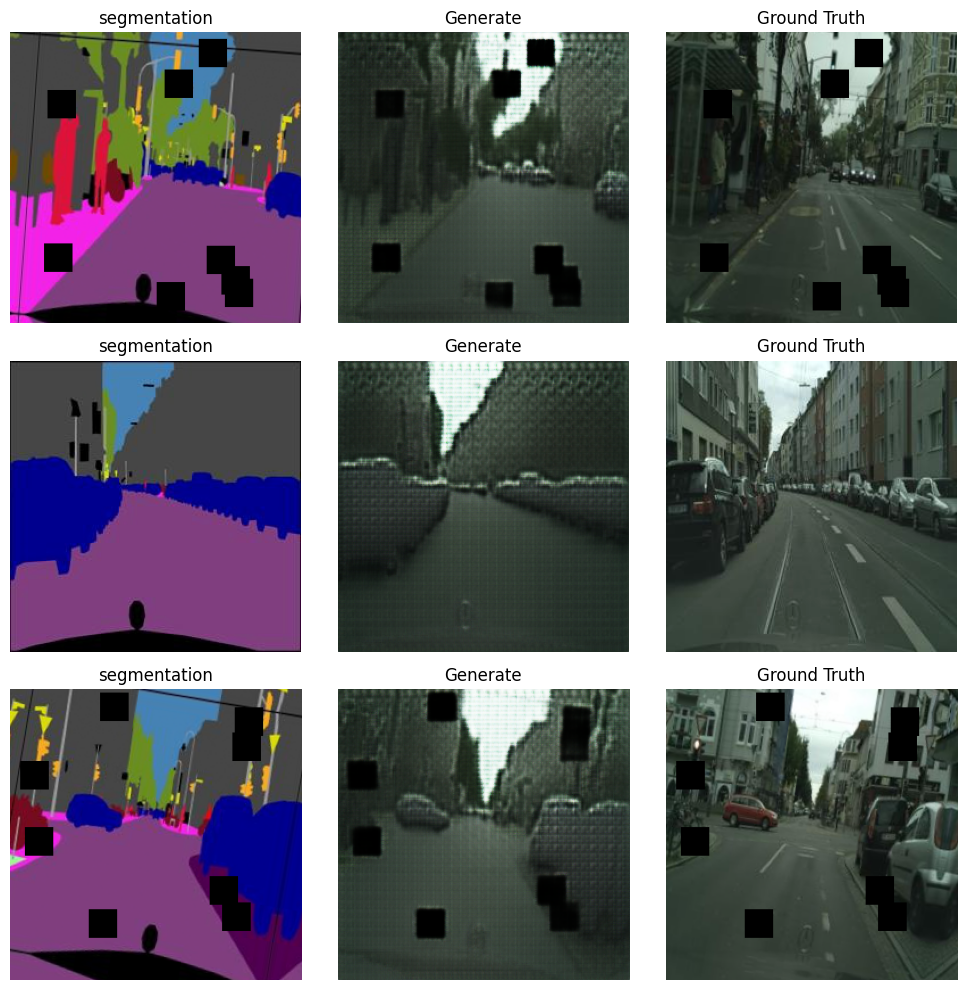

In [24]:
plt.figure(figsize=(10, 10))

num_samples = 3

for i in range(num_samples):
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(to_pil_image(0.5 * real_imgs[i] + 0.5))
    plt.axis('off')
    plt.title('segmentation')

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(to_pil_image(0.5 * fake_imgs[i] + 0.5))
    plt.axis('off')
    plt.title('Generate')

    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(to_pil_image(0.5 * ground_truth[i] + 0.5))
    plt.axis('off')
    plt.title('Ground Truth')

plt.tight_layout()
plt.show()

### Val dataset Generate

In [25]:
#evaluation model
model_gen.eval()

#Generate fake image
with torch.no_grad():
    for a,b in val_dl:
        ground_truth = b
        fake_imgs = model_gen(a.to(device)).detach().cpu()
        real_imgs = a
        break

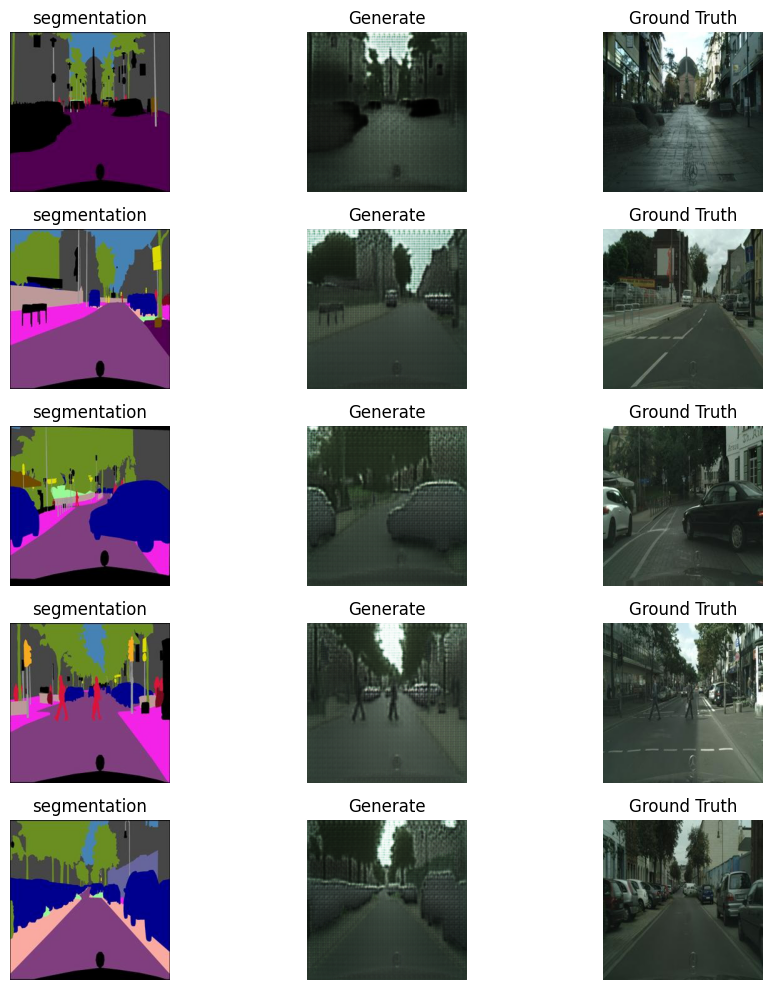

In [26]:
plt.figure(figsize=(10, 10))

num_samples = 5

for i in range(num_samples):
    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(to_pil_image(0.5 * real_imgs[i] + 0.5))
    plt.axis('off')
    plt.title('segmentation')

    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(to_pil_image(0.5 * fake_imgs[i] + 0.5))
    plt.axis('off')
    plt.title('Generate')

    plt.subplot(5, 3, i * 3 + 3)
    plt.imshow(to_pil_image(0.5 * ground_truth[i] + 0.5))
    plt.axis('off')
    plt.title('Ground Truth')

plt.tight_layout()
plt.show()